<a href="https://colab.research.google.com/github/ParekhJash1/Cancer-detection-through-image-using-CNN-and-Unet/blob/main/cancer_detection_using_CNN_and_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-ultrasound-images-dataset' dataset.
Path to dataset files: /kaggle/input/breast-ultrasound-images-dataset


In [4]:
import tensorflow
from tensorflow import keras
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from keras.models import Sequential
import matplotlib.pyplot as plt
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

In [5]:
folder_paths = ["/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant", "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign"] # Paths to the 2 folders
size = 128 # Input size: 128x128

images = [] # Empty list to store the original images in
masks = [] # Empty list to store the masks in

In [6]:
found_mask = False # This flag helps us handle multiple masks for the same image
# Loop through both folders
for folder_path in folder_paths:
    # Loop through all files in the current folder (sorted for consistency)
    for file_path in sorted(glob(folder_path + "/*")):
        # Load and resize the image
        img = cv2.imread(file_path)
        img = cv2.resize(img, (size, size)) # Resize image to 128x128
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Convert RGB to grayscale
        img = img / 255.0 # Normalize to [0,1]

        if "mask" in file_path: # Checks if the filename contains "mask"
            if found_mask:
                # Combine with the previous mask
                masks[-1] += img
                # Ensure binary output (0 or 1)
                masks[-1] = np.where(masks[-1] > 0.5, 1.0, 0.0)
            else:
                masks.append(img) # Adds the first mask
                found_mask = True
        else:
            images.append(img) # Adds original image
            found_mask = False

In [7]:
# Convert lists to NumPy arrays
X = np.array(images) # Create an array of all original images
y = np.array(masks) # Create an array of all masked images (Ground truth)

# Add a channel dimension (needed for Keras/TensorFlow)
X = np.expand_dims(X, -1)
y = np.expand_dims(y, -1)


# Print shapes and split the data
print(f"X shape: {X.shape} | y shape: {y.shape}")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

X shape: (647, 128, 128, 1) | y shape: (647, 128, 128, 1)


In [8]:
import os
print(os.listdir(path))

['Dataset_BUSI_with_GT']


In [9]:
# --- U-Net Model Architecture (Encoder & Bottleneck) ---
input_layer = Input(shape=(size, size, 1))

# First encoder block
conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(input_layer)
conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

# Second encoder block
conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool1)
conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

# Third encoder block
conv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(pool2)
conv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

# Fourth encoder block
conv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(pool3)
conv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(conv4)
pool4 = MaxPooling2D((2, 2))(conv4)

# --- Bottleneck ---
bottleneck = Conv2D(1024, (3, 3), activation="relu", padding="same")(pool4)
bottleneck = Conv2D(1024, (3, 3), activation="relu", padding="same")(bottleneck)

In [10]:
# First decoder block
upconv1 = Conv2DTranspose(512, (2, 2), strides=2, padding="same")(bottleneck)
concat1 = concatenate([upconv1, conv4])
conv5 = Conv2D(512, (3, 3), activation="relu", padding="same")(concat1)
conv5 = Conv2D(512, (3, 3), activation="relu", padding="same")(conv5)

# Second decoder block
upconv2 = Conv2DTranspose(256, (2, 2), strides=2, padding="same")(conv5)
concat2 = concatenate([upconv2, conv3])
conv6 = Conv2D(256, (3, 3), activation="relu", padding="same")(concat2)
conv6 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv6)

# Third decoder block
upconv3 = Conv2DTranspose(128, (2, 2), strides=2, padding="same")(conv6)
concat3 = concatenate([upconv3, conv2])
conv7 = Conv2D(128, (3, 3), activation="relu", padding="same")(concat3)
conv7 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv7)

# Fourth decoder block
upconv4 = Conv2DTranspose(64, (2, 2), strides=2, padding="same")(conv7)
concat4 = concatenate([upconv4, conv1])
conv8 = Conv2D(64, (3, 3), activation="relu", padding="same")(concat4)
conv8 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv8)

In [11]:
# --- Output layer ---
output_layer = Conv2D(1, (1, 1), activation="sigmoid", padding="same")(conv8)

# --- Model creation ---
model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# --- Model Compilation ---
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

# --- Model Training ---
model.fit(X_train, y_train, epochs=40, validation_data=(X_val, y_val), verbose=1)

Epoch 1/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.7604 - loss: 0.7947 - val_accuracy: 0.9230 - val_loss: 0.3838
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 410ms/step - accuracy: 0.9041 - loss: 0.3541 - val_accuracy: 0.9230 - val_loss: 0.2810
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step - accuracy: 0.9003 - loss: 0.3249 - val_accuracy: 0.9230 - val_loss: 0.2668
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 421ms/step - accuracy: 0.9085 - loss: 0.2968 - val_accuracy: 0.9230 - val_loss: 0.2559
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 425ms/step - accuracy: 0.9068 - loss: 0.3678 - val_accuracy: 0.9230 - val_loss: 0.2762
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 420ms/step - accuracy: 0.9048 - loss: 0.3123 - val_accuracy: 0.9230 - val_loss: 0.2647
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step - accuracy: 0.9033 - loss: 0.2995 - val_accuracy: 0.9230 - val_loss: 0.2756
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 408ms/step - accuracy: 0.9073 - loss: 0.2891 - val_accuracy: 0.9

In [13]:
from sklearn.metrics import jaccard_score
# Compute predicted mask
pred=model.predict(X_val,verbose=1)
pred = (pred > 0.5).astype(int) # binarize
y_true = y_val.astype(int)
# Compute IoU based on flatten predictions and ground truths
iou = jaccard_score(pred.flatten(), y_true.flatten())
print(f" IoU (Jaccard Score): {iou:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 534ms/step
 IoU (Jaccard Score): 0.5458


In [14]:
from keras.metrics import MeanIoU
mean_iou = MeanIoU(num_classes=2)
mean_iou.update_state(pred, y_true)
print("Mean IoU =", mean_iou.result().numpy())

Mean IoU = 0.7504685


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


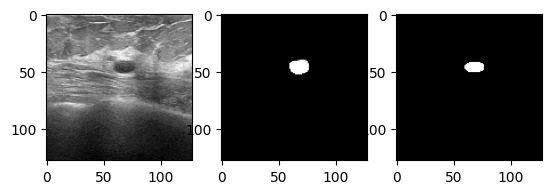

In [15]:
i = 6
plt.subplot(1, 3, 1)
plt.imshow(X_val[i], cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(y_val[i], cmap="gray")
plt.subplot(1, 3, 3)
pred = model.predict(np.expand_dims(X_val[i], axis=0), verbose=1)[0]
pred = (pred > 0.5) # binarize
plt.imshow(pred, cmap="gray")

In [16]:
conv1 = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(input_layer)
conv1 = Conv2D(64, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

In [17]:
from sklearn.metrics import jaccard_score
# Compute predicted mask
pred=model.predict(X_val,verbose=1)
pred = (pred > 0.5).astype(int) # binarize
y_true = y_val.astype(int)
# Compute IoU based on flatten predictions and ground truths
iou = jaccard_score(pred.flatten(), y_true.flatten())
print(f" IoU (Jaccard Score): {iou:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step 
 IoU (Jaccard Score): 0.5458
